### Metadata

In [1]:
%cd ..

/Users/davidrestrepo/Data Fusion/DF-DM


In [2]:
from src.Preprocessing.time_series_preprocessing import get_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor
from src.Preprocessing.time_series_preprocessing import read_static, read_features
from src.Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np
import random
import tensorflow as tf
import torch

def set_all_seeds(seed):
    """
    Set seed for reproducibility in different libraries.
    :param seed: An integer representing the seed value.
    """
    random.seed(seed)  # Python's built-in random module
    np.random.seed(seed)  # Numpy library
    os.environ['PYTHONHASHSEED'] = str(seed)  # Environment variable

    # TensorFlow
    tf.random.set_seed(seed)
    if tf.__version__[0] == '2':
        # For TensorFlow 2.x, additionally set the global random seed
        tf.compat.v1.set_random_seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        # If using GPU with PyTorch, set additional seeds
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # for multi-GPU

In [3]:
DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
cohort = 'cities.csv'

In [4]:
cities = pd.read_csv(DIR_PATH + cohort)
cities

,lat,lng,Municipality,Municipality code,ISO
0,6.2447,-75.5748,Medellín,5001,CO-ANT
1,3.4400,-76.5197,Cali,76001,CO-VAC
2,4.5781,-74.2144,Soacha,25754,CO-CUN
3,4.1425,-73.6294,Villavicencio,50001,CO-MET
4,1.2136,-77.2811,Pasto,52001,CO-NAR
5,10.9639,-74.7964,Barranquilla,8001,CO-ATL
6,7.1186,-73.1161,Bucaramanga,68001,CO-SAN
7,4.4378,-75.2006,Ibagué,73001,CO-TOL
8,2.4411,-76.6061,Popayán,19001,CO-CAU
9,7.9075,-72.5047,Cúcuta,54001,CO-NSA


##### Constants

In [5]:
""" Read Dataset:"""
image_embeddings = 'Embeddings/Embeddings_dinov2_large.csv'
media_data = None # 'datasets/violence_prediction/media_data.csv'
static = 'datasets/violence_prediction/metadata_labels.csv'

DIR_PATH = 'datasets/violence_prediction/'
file = 'metadata_labels.csv'
labels = pd.read_csv(DIR_PATH + file)

# Get list of municipalities:
cohort = 'cities.csv'
cities = pd.read_csv(DIR_PATH + cohort)
Municipalities = cities.Municipality.values

""" Dataset Preprocessing:"""
train_percentage = 80
T = 3
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

seed = 1
n_tests = 3

### Read and Preprocess the Data

#### Read the Data

In [6]:
# Read dataset
dengue_df = [get_dataset(labels_path=labels, embeddings_path=image_embeddings, municipality=Municipality, temp_prec=media_data, static=static) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Medellín only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Cali only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Soacha only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Villavicencio only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Pasto only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Barranquilla only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Bucaramanga only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Ibagué only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Popayán only...
Obtaining dataframe for the city of Cúcuta onl

list

#### Train-Test Split

In [8]:
train_df = []
test_df = []

for i in range(len(dengue_df)):
    train_df_aux, test_df_aux = train_test_split(dengue_df[i], train_percentage)
    train_df.append(train_df_aux)
    test_df.append(test_df_aux)
#test_df

The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)
The train shape is: (210, 1051)
The test shape is: (53, 1051)


#### Normalize the Data

In [9]:
scalers_list = []
# Scale train:
for i in range(len(train_df)):
    train_df[i], scalers = normalize_train_features(train_df[i], feature_range=feature_range)
    scalers_list.append(scalers)


In [10]:
# Scale test:
for i in range(len(test_df)):
    test_df[i] = normalize_test_features(test_df[i], scalers=scalers_list[i])


#### Prepare data for time series supervised learning (function to create sliding window)

In [11]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(208, 3151)

#### Features and Labels Set

In [12]:
# Train features and labels set
print('Train:')
train_X = []
train_y = []
n_features = []

for i in range(len(train)):
    train_X_aux, train_y_aux, n_features_aux = features_labels_set(timeseries_data=train[i], original_df=dengue_df[i], autoregressive=autoregressive)
    train_X.append(train_X_aux)
    train_y.append(train_y_aux)
    n_features.append(n_features_aux)  
    
# Test features and labels set
print('Test:')
test_X = []
test_y = []
n_features = []
for i in range(len(test)):
    test_X_aux, test_y_aux, n_features_aux = features_labels_set(timeseries_data=test[i], original_df=dengue_df[i], autoregressive=autoregressive)
    test_X.append(test_X_aux)
    test_y.append(test_y_aux)
    n_features.append(n_features_aux)


Train:
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
The shape of the features is (208, 3150)
The shape of the labels is (208, 1)
Test:
The shape of the features is (51, 3150)
The shape of the labels is (51, 1)
The shape of the features is (51, 3150)
The shape of the labels is (51, 1)
The shape of the features is (51, 3150)
The shape of the labels is 

In [13]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    for i in range(len(train_X)):
        train_X[i], test_X[i] = reshape_tensor(train_X[i], test_X[i], n_features[i], T, autoregressive)

The initial shapes are:
The train shape is (208, 3150)
The test shape is (51, 3150)
-----------------------
The Final shapes are:
The train shape is (208, 3, 1050)
The test shape is (51, 3, 1050)
The initial shapes are:
The train shape is (208, 3150)
The test shape is (51, 3150)
-----------------------
The Final shapes are:
The train shape is (208, 3, 1050)
The test shape is (51, 3, 1050)
The initial shapes are:
The train shape is (208, 3150)
The test shape is (51, 3150)
-----------------------
The Final shapes are:
The train shape is (208, 3, 1050)
The test shape is (51, 3, 1050)
The initial shapes are:
The train shape is (208, 3150)
The test shape is (51, 3150)
-----------------------
The Final shapes are:
The train shape is (208, 3, 1050)
The test shape is (51, 3, 1050)
The initial shapes are:
The train shape is (208, 3150)
The test shape is (51, 3150)
-----------------------
The Final shapes are:
The train shape is (208, 3, 1050)
The test shape is (51, 3, 1050)
The initial shapes a

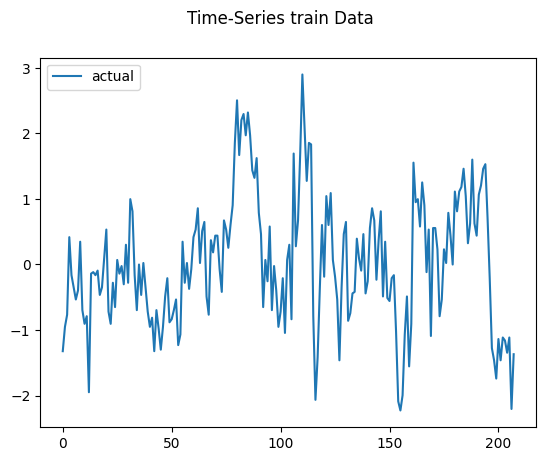

2024-01-16 15:49:44.851576: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-16 15:49:44.851609: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-16 15:49:44.851613: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-16 15:49:44.852024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-16 15:49:44.852428: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-01-16 15:49:47.165980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:49:47.484101: I te

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 15:50:00.563175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:00.671439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:00.721133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 44ms/step
Test MAE: 23.978
Test RMSE: 32.401
Test sMAPE: 14.474
Test R Squared: 0.097
{'mae': 23.978107826382505, 'rmse': 32.4014557092486, 'smape': 14.473990799366382, 'r2': 0.09670875330929696}


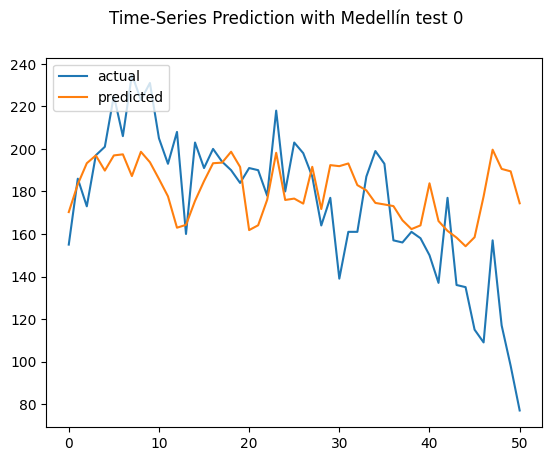

2024-01-16 15:50:02.543167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:02.830003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:02.878998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:03.208394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:03.321245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:05.046186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:05.164556: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 15:50:11.476647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:11.666071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 51ms/step


2024-01-16 15:50:11.747261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 27.262
Test RMSE: 34.481
Test sMAPE: 16.368
Test R Squared: -0.023
{'mae': 27.262135524375765, 'rmse': 34.48104733464082, 'smape': 16.367741552271962, 'r2': -0.02296236099647908}


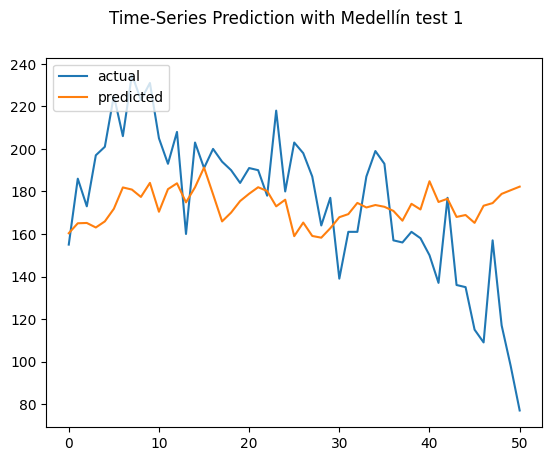

2024-01-16 15:50:13.848306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:14.176125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:14.216997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:14.490154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:14.582445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:16.327548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:16.517765: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 11.
Epoch 19: early stopping


2024-01-16 15:50:28.548621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:28.663540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:28.721364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 61ms/step
Test MAE: 23.373
Test RMSE: 31.120
Test sMAPE: 14.160
Test R Squared: 0.167
{'mae': 23.373150993795957, 'rmse': 31.11959753691165, 'smape': 14.159552469611771, 'r2': 0.16676654185173867}


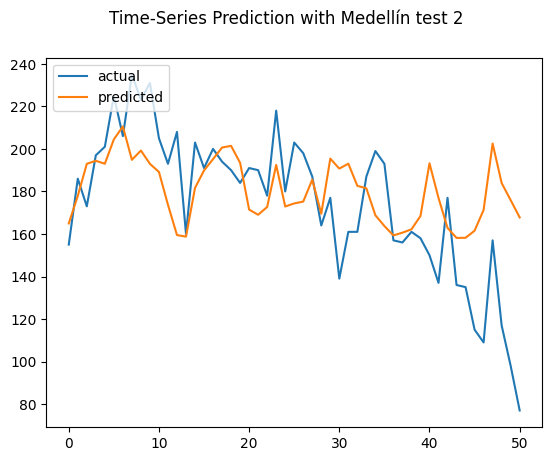

rmse : average=32.667, std=1.385
mae : average=24.871, std=1.709
smape : average=15.000, std=0.975
r2 : average=0.080, std=0.078


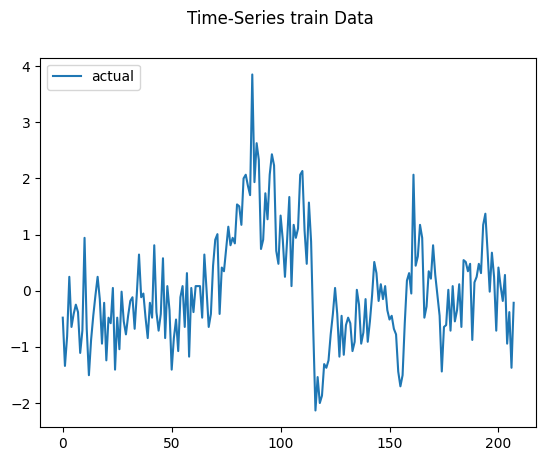

2024-01-16 15:50:32.031530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:32.457898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:32.522960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:32.880862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:33.011758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:34.367644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:34.507129: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping


2024-01-16 15:50:47.970413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:48.091611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:48.138909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 39ms/step
Test MAE: 19.993
Test RMSE: 24.577
Test sMAPE: 18.124
Test R Squared: -0.071
{'mae': 19.993465348786, 'rmse': 24.577310044754146, 'smape': 18.12398390159968, 'r2': -0.070757968169044}


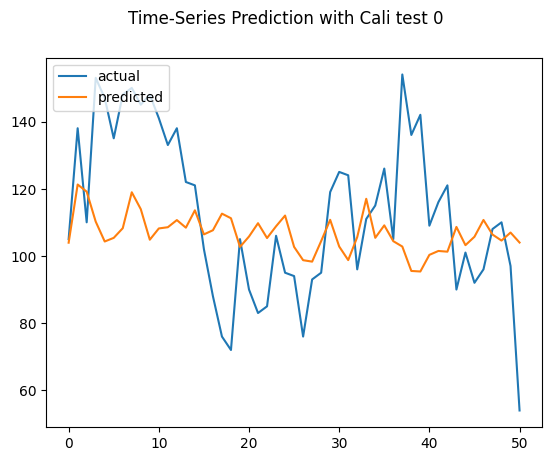

2024-01-16 15:50:50.050331: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:50.356287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:50.413080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:50.756295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:50.883703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:52.429652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:52.563277: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping


2024-01-16 15:50:59.557555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:59.674152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:50:59.724784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 40ms/step
Test MAE: 20.214
Test RMSE: 25.063
Test sMAPE: 18.314
Test R Squared: -0.114
{'mae': 20.21430296056411, 'rmse': 25.06320303787437, 'smape': 18.314286709541, 'r2': -0.11351420919335742}


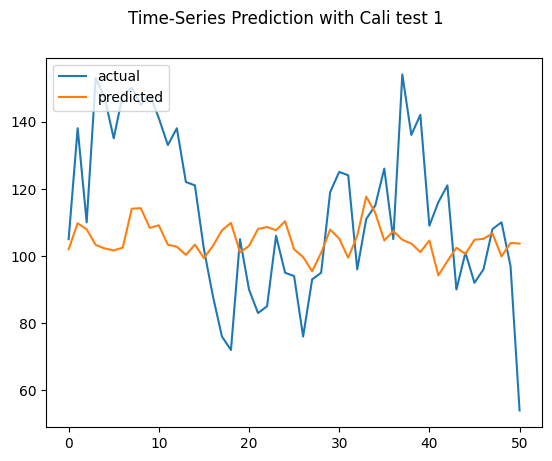

2024-01-16 15:51:03.740426: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:04.094546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:04.146752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:04.505767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:04.607485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:06.075539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:06.245129: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 15:51:11.791243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:11.960999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 44ms/step
Test MAE: 20.650
Test RMSE: 24.684
Test sMAPE: 18.609
Test R Squared: -0.080
{'mae': 20.649775486366423, 'rmse': 24.683740290952695, 'smape': 18.60889113790295, 'r2': -0.0800517260238387}


2024-01-16 15:51:12.022103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


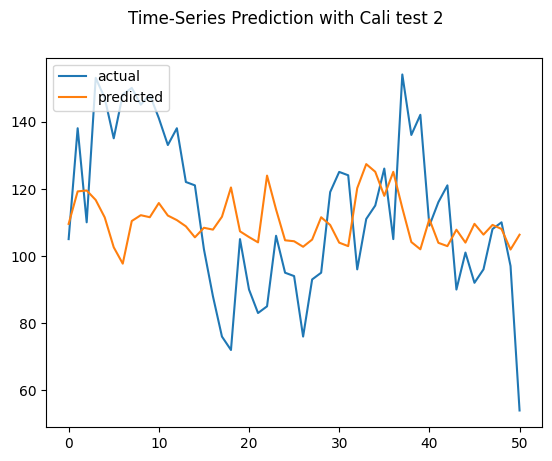

rmse : average=24.775, std=0.209
mae : average=20.286, std=0.273
smape : average=18.349, std=0.199
r2 : average=-0.088, std=0.018


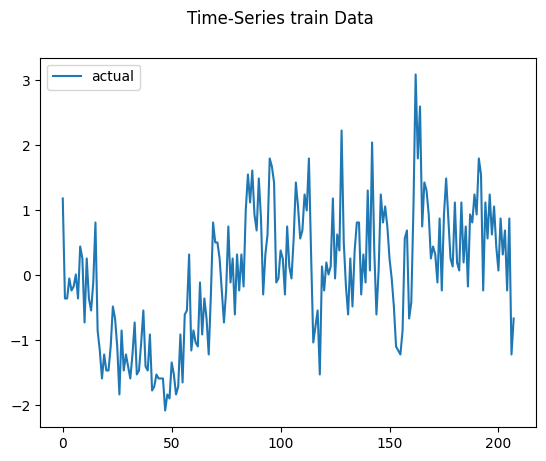

2024-01-16 15:51:14.423090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:14.716683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:14.770362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:15.023959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:15.158788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:16.284150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:16.406013: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping


2024-01-16 15:51:29.413584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:29.527009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:29.574985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 47ms/step
Test MAE: 20.591
Test RMSE: 26.787
Test sMAPE: 37.847
Test R Squared: -0.439
{'mae': 20.591121149998084, 'rmse': 26.787375310850944, 'smape': 37.846925655266716, 'r2': -0.4392238430283282}


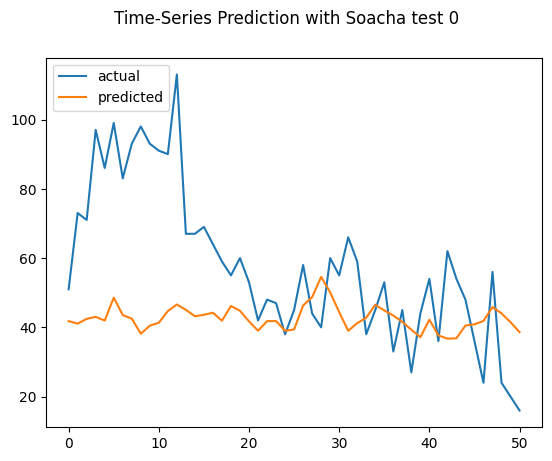

2024-01-16 15:51:31.695208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:32.016287: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:32.076475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:32.482395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:32.636719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:34.124999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:34.251518: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping


2024-01-16 15:51:47.542910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:47.701541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 87ms/step


2024-01-16 15:51:47.785950: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 20.150
Test RMSE: 26.796
Test sMAPE: 36.819
Test R Squared: -0.440
{'mae': 20.150395860858993, 'rmse': 26.7958448169467, 'smape': 36.81921267650241, 'r2': -0.4401340809282297}


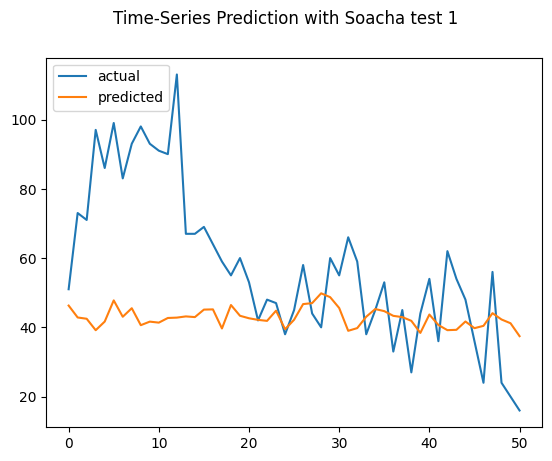

2024-01-16 15:51:49.887393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:50.195405: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:50.253121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:50.601497: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:50.756392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:52.247995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:51:52.394235: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 11.
Epoch 19: early stopping


2024-01-16 15:52:04.169832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:04.290953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 60ms/step


2024-01-16 15:52:04.390879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 20.609
Test RMSE: 26.861
Test sMAPE: 37.899
Test R Squared: -0.447
{'mae': 20.608879463345396, 'rmse': 26.861236778637792, 'smape': 37.89909050510794, 'r2': -0.4471715975535058}


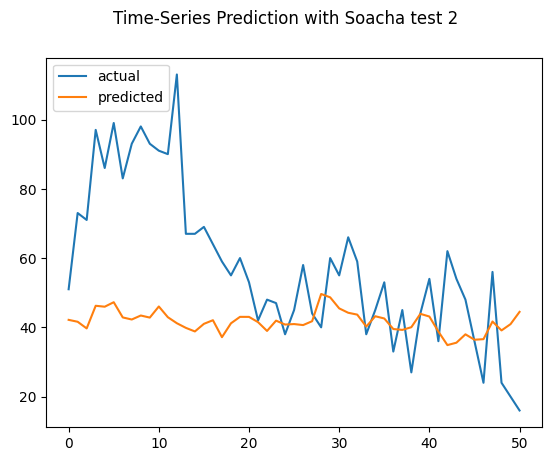

rmse : average=26.815, std=0.033
mae : average=20.450, std=0.212
smape : average=37.522, std=0.497
r2 : average=-0.442, std=0.004


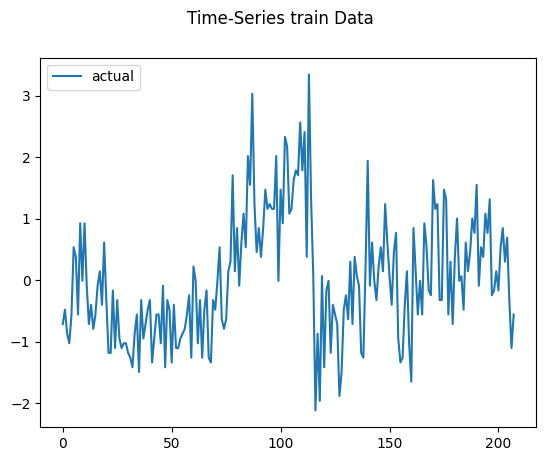

2024-01-16 15:52:09.487193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:09.893078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:09.975351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:10.583643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:10.755931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:12.045689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:12.185914: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 11.
Epoch 19: early stopping


2024-01-16 15:52:23.775478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:23.907985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:23.971214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 66ms/step
Test MAE: 10.238
Test RMSE: 13.658
Test sMAPE: 23.214
Test R Squared: -0.229
{'mae': 10.238471087287454, 'rmse': 13.658461530536924, 'smape': 23.214320227124748, 'r2': -0.22942828842490948}


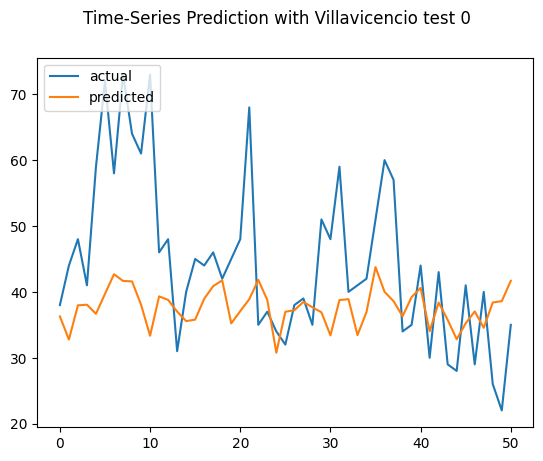

2024-01-16 15:52:26.058976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:26.378900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:26.443296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:26.820448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:26.939881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:28.101400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:28.289185: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 15:52:34.184507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:34.300614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:34.358292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 65ms/step
Test MAE: 10.349
Test RMSE: 14.179
Test sMAPE: 23.390
Test R Squared: -0.325
{'mae': 10.34890806908701, 'rmse': 14.178718740623633, 'smape': 23.389801367630593, 'r2': -0.3248710471170695}


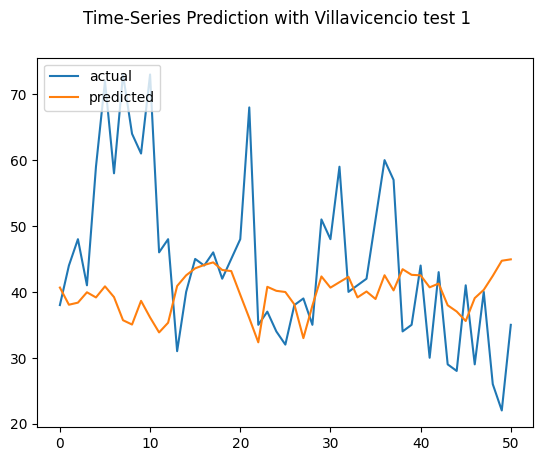

2024-01-16 15:52:36.548997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:36.892864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:36.953499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:37.428994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:37.600293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:38.857534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:38.989670: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2024-01-16 15:52:45.350851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:45.507730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 99ms/step


2024-01-16 15:52:45.582139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 10.267
Test RMSE: 13.846
Test sMAPE: 23.226
Test R Squared: -0.263
{'mae': 10.267124662212296, 'rmse': 13.845774130296444, 'smape': 23.2256893718498, 'r2': -0.26338035440703633}


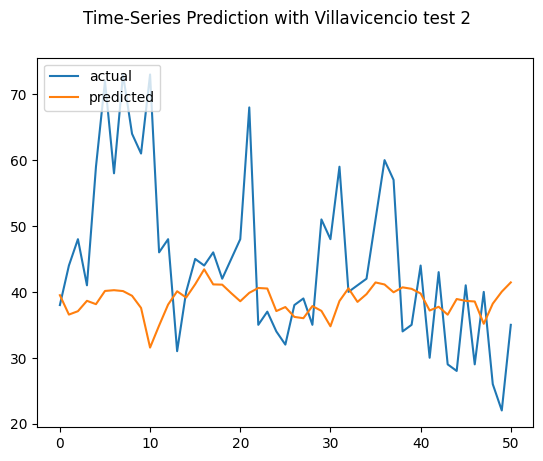

rmse : average=13.894, std=0.215
mae : average=10.285, std=0.047
smape : average=23.277, std=0.080
r2 : average=-0.273, std=0.040


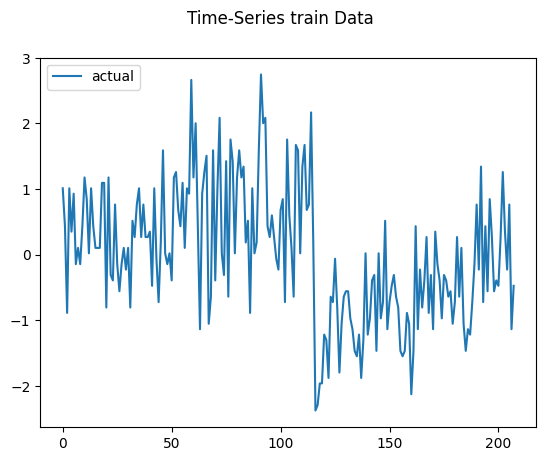

2024-01-16 15:52:48.733271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:49.081973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:49.156444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:49.689226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:49.865744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:51.163668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:52:51.316890: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 19.
Epoch 27: early stopping


2024-01-16 15:53:07.742397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:07.902619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 77ms/step


2024-01-16 15:53:07.997888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 12.178
Test RMSE: 16.251
Test sMAPE: 28.961
Test R Squared: -0.416
{'mae': 12.178498810412837, 'rmse': 16.250846875302503, 'smape': 28.96095508300862, 'r2': -0.4155551836206912}


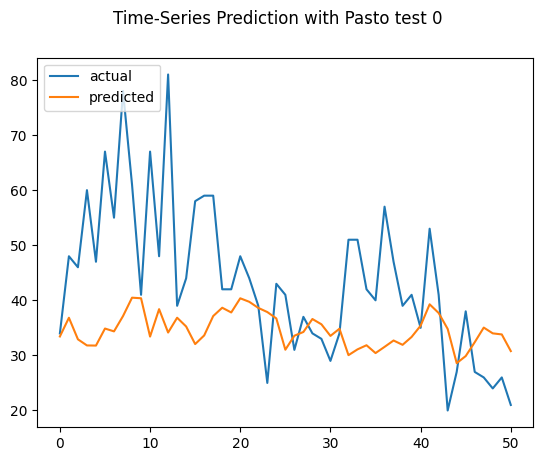

2024-01-16 15:53:10.427230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:10.810073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:10.904456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:11.455719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:11.694971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:15.637307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:15.849929: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping


2024-01-16 15:53:29.837065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:29.985615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 84ms/step


2024-01-16 15:53:30.072575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 12.411
Test RMSE: 16.658
Test sMAPE: 29.501
Test R Squared: -0.487
{'mae': 12.411471161187864, 'rmse': 16.658391123756385, 'smape': 29.500683431273163, 'r2': -0.4874450047566208}


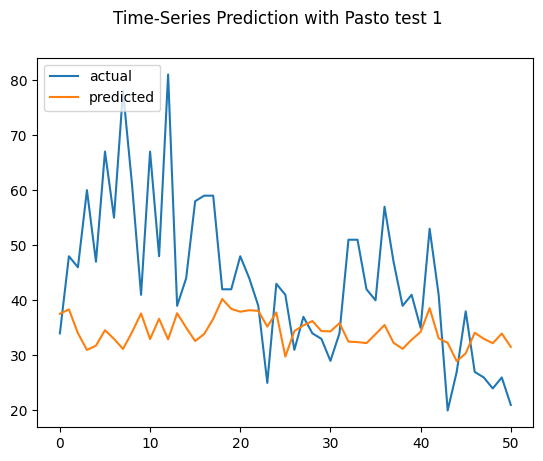

2024-01-16 15:53:32.666931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:33.058269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:33.152867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:33.627151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:33.813599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:35.337036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:35.528453: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 25.
Epoch 33: early stopping


2024-01-16 15:53:57.323069: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:53:57.487722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2024-01-16 15:53:57.612289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 116ms/step
Test MAE: 12.130
Test RMSE: 16.221
Test sMAPE: 28.890
Test R Squared: -0.410
{'mae': 12.130212260227577, 'rmse': 16.221498974694402, 'smape': 28.889880562116755, 'r2': -0.4104470116282659}


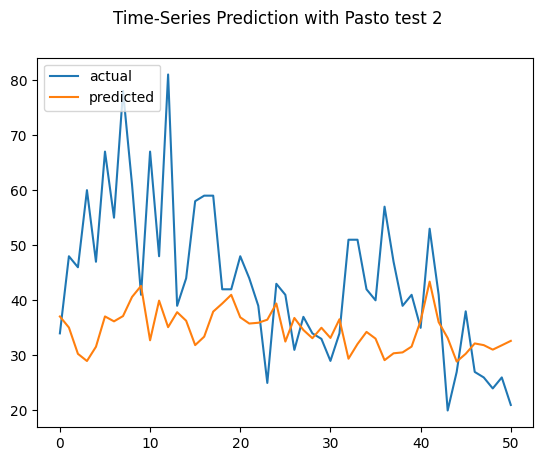

rmse : average=16.377, std=0.199
mae : average=12.240, std=0.123
smape : average=29.117, std=0.273
r2 : average=-0.438, std=0.035


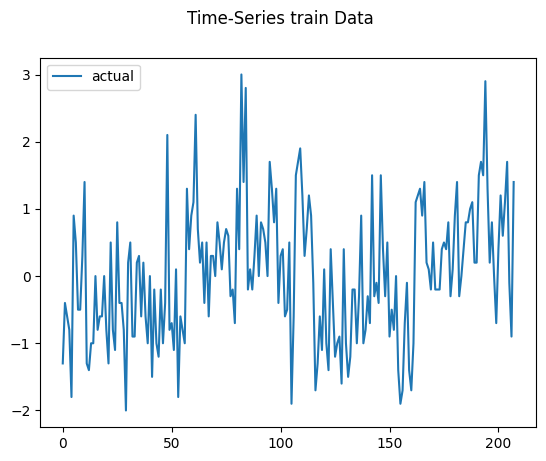

2024-01-16 15:54:01.980349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:02.405156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:02.490194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:03.135396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:03.341386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:05.064288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:05.266907: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 19.
Epoch 27: early stopping


2024-01-16 15:54:22.790257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:22.948038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 82ms/step


2024-01-16 15:54:23.057842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 16.375
Test RMSE: 18.315
Test sMAPE: 38.521
Test R Squared: -2.805
{'mae': 16.374539431403665, 'rmse': 18.314524818325133, 'smape': 38.52079361335559, 'r2': -2.8051280631113475}


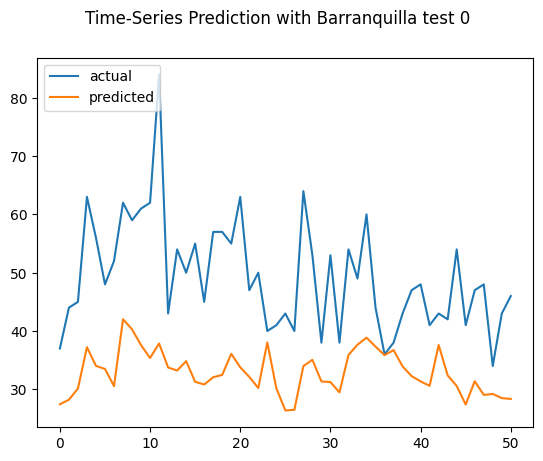

2024-01-16 15:54:25.599415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:25.991863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:26.078278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:26.606158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:26.851897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:28.433654: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:28.608957: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 15:54:41.221281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:41.392691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2024-01-16 15:54:41.503923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 114ms/step
Test MAE: 15.559
Test RMSE: 17.939
Test sMAPE: 36.254
Test R Squared: -2.651
{'mae': 15.558527142393823, 'rmse': 17.939072726335173, 'smape': 36.25420163106995, 'r2': -2.6507151539188714}


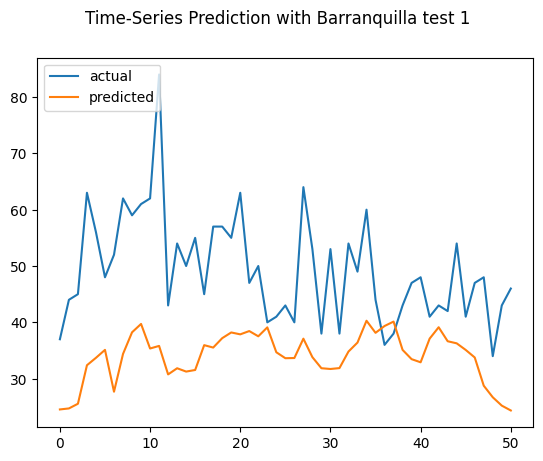

2024-01-16 15:54:44.260291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:44.720819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:44.813479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:45.521133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:45.774203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:47.492227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:54:47.660315: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 10.
Epoch 18: early stopping


2024-01-16 15:55:06.425728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:06.606335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:06.803967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 6s 111ms/step
Test MAE: 16.068
Test RMSE: 18.325
Test sMAPE: 37.555
Test R Squared: -2.809
{'mae': 16.067565020392923, 'rmse': 18.324642665923434, 'smape': 37.554666729535114, 'r2': -2.80933350559873}


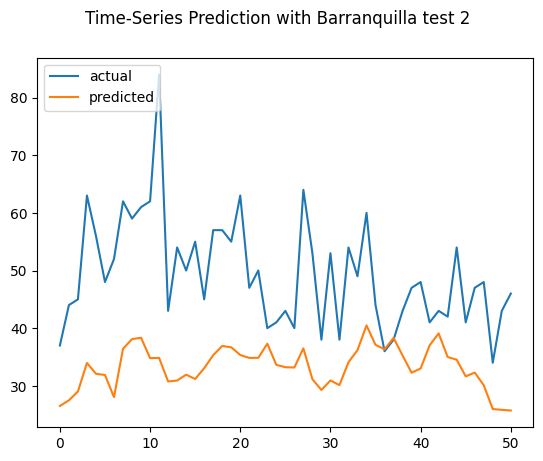

rmse : average=18.193, std=0.179
mae : average=16.000, std=0.337
smape : average=37.443, std=0.929
r2 : average=-2.755, std=0.074


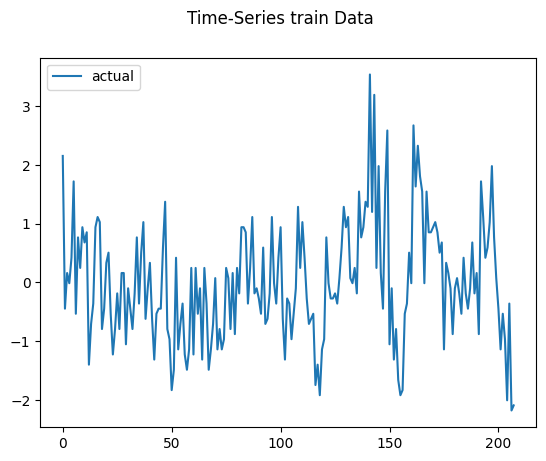

2024-01-16 15:55:11.201574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:11.732406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:11.837978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:12.757418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:13.285773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:17.048009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:17.233643: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2024-01-16 15:55:24.254386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:24.395163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 86ms/step


2024-01-16 15:55:24.497247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 8.085
Test RMSE: 10.527
Test sMAPE: 29.220
Test R Squared: -0.287
{'mae': 8.085260914821252, 'rmse': 10.527277508948377, 'smape': 29.219838182128402, 'r2': -0.28729952716513596}


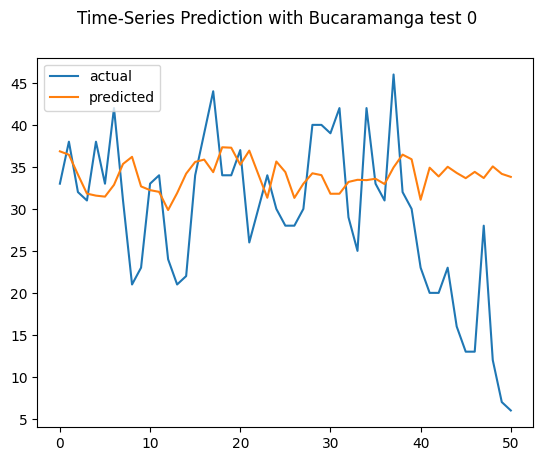

2024-01-16 15:55:27.049887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:27.580160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:27.679706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:28.350684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:28.563308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:30.136372: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:30.297205: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 18.
Epoch 26: early stopping


2024-01-16 15:55:47.509051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:47.701451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2024-01-16 15:55:47.844258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 98ms/step
Test MAE: 8.331
Test RMSE: 10.808
Test sMAPE: 29.868
Test R Squared: -0.357
{'mae': 8.33136547313017, 'rmse': 10.808146828899362, 'smape': 29.86849064604023, 'r2': -0.3569065492720529}


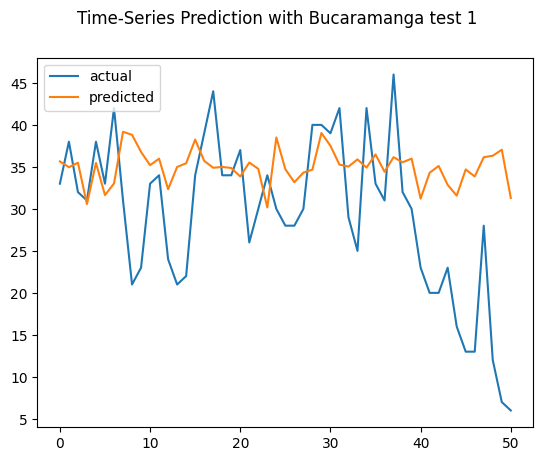

2024-01-16 15:55:50.408022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:50.759363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:50.849223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:51.533196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:51.787063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:53.682110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:55:53.929382: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping


2024-01-16 15:56:03.057660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:03.297936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:03.438640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 102ms/step
Test MAE: 8.308
Test RMSE: 10.755
Test sMAPE: 29.853
Test R Squared: -0.344
{'mae': 8.30804391000785, 'rmse': 10.754882650462305, 'smape': 29.853067081478763, 'r2': -0.34356542357263464}


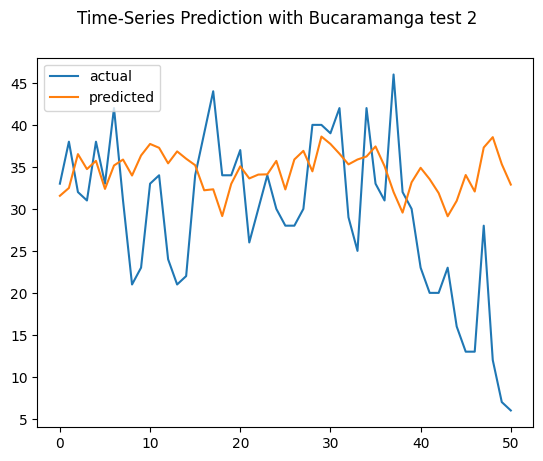

rmse : average=10.697, std=0.122
mae : average=8.242, std=0.111
smape : average=29.647, std=0.302
r2 : average=-0.329, std=0.030


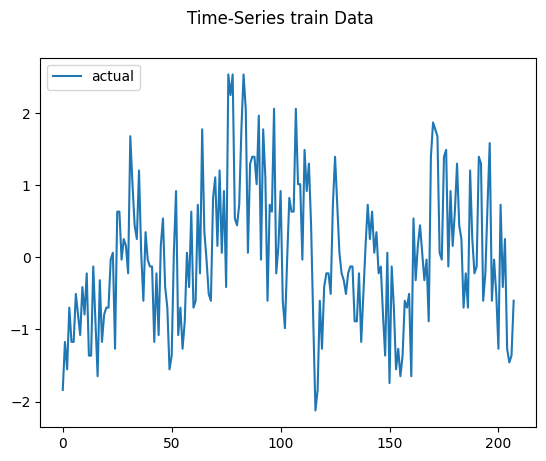

2024-01-16 15:56:09.815712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:10.324627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:10.445486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:11.334045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:11.685179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:13.689475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:13.958610: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 15:56:28.541593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:28.709364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 1s

2024-01-16 15:56:28.842080: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 88ms/step
Test MAE: 9.907
Test RMSE: 12.392
Test sMAPE: 27.803
Test R Squared: -0.743
{'mae': 9.9069626752068, 'rmse': 12.392354743853542, 'smape': 27.803058350628604, 'r2': -0.7434278569666184}


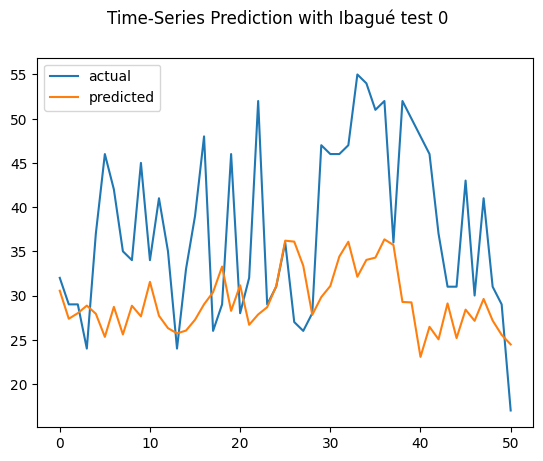

2024-01-16 15:56:37.756306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:38.321948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:38.468567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:39.321734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:39.709700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:43.440668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:43.620609: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping


2024-01-16 15:56:52.661012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:52.866718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:52.998365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 116ms/step
Test MAE: 10.046
Test RMSE: 12.272
Test sMAPE: 28.658
Test R Squared: -0.710
{'mae': 10.045815299539004, 'rmse': 12.272472506860897, 'smape': 28.65787278971028, 'r2': -0.7098595666000562}


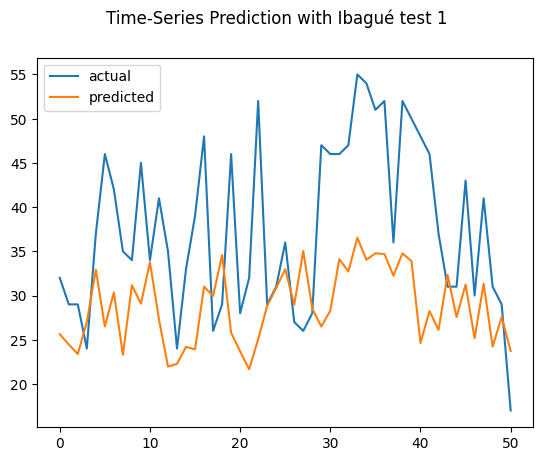

2024-01-16 15:56:55.617173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:56.060542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:56.198882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:57.199997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:57.580744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:59.530546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:56:59.772388: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 24.
Epoch 32: early stopping


2024-01-16 15:57:20.149289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:20.405967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:20.521624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 104ms/step
Test MAE: 9.896
Test RMSE: 12.312
Test sMAPE: 27.709
Test R Squared: -0.721
{'mae': 9.895678613700118, 'rmse': 12.312143052691807, 'smape': 27.709033551079955, 'r2': -0.7209316131832417}


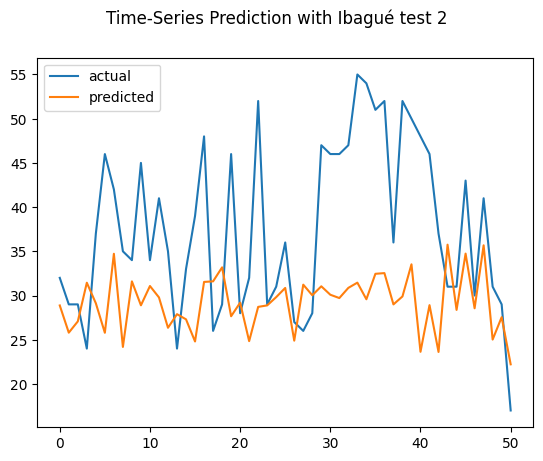

rmse : average=12.326, std=0.050
mae : average=9.949, std=0.068
smape : average=28.057, std=0.427
r2 : average=-0.725, std=0.014


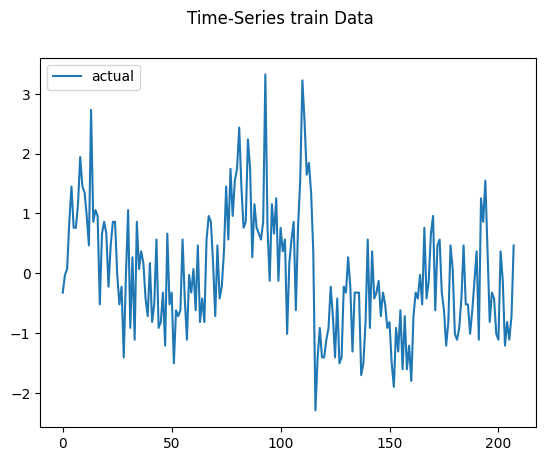

2024-01-16 15:57:25.133936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:25.556839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:25.663995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:26.275428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:26.571892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:29.061186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:29.338646: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping


2024-01-16 15:57:37.745609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:37.991195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:38.145406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 124ms/step
Test MAE: 6.620
Test RMSE: 8.146
Test sMAPE: 22.740
Test R Squared: -0.035
{'mae': 6.61997828764074, 'rmse': 8.145668887748819, 'smape': 22.73982377513767, 'r2': -0.03510716950128612}


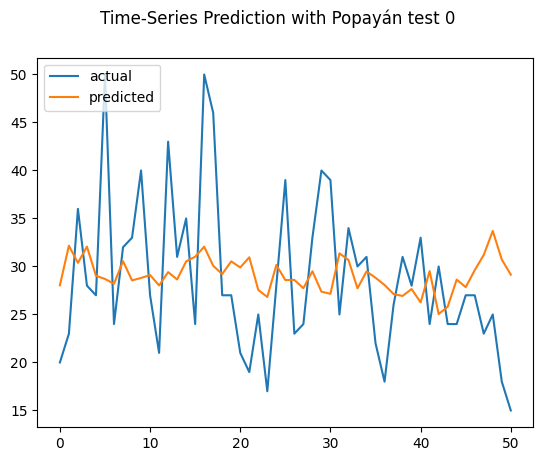

2024-01-16 15:57:41.430770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:41.931249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:42.070565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:42.952375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:43.237436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:45.131419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:45.419003: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 8.
Epoch 16: early stopping


2024-01-16 15:57:56.927157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:57:57.073257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 83ms/step


2024-01-16 15:57:57.178237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Test MAE: 6.842
Test RMSE: 8.322
Test sMAPE: 23.442
Test R Squared: -0.081
{'mae': 6.841643613927505, 'rmse': 8.322424031799724, 'smape': 23.44193645634248, 'r2': -0.08051671783363767}


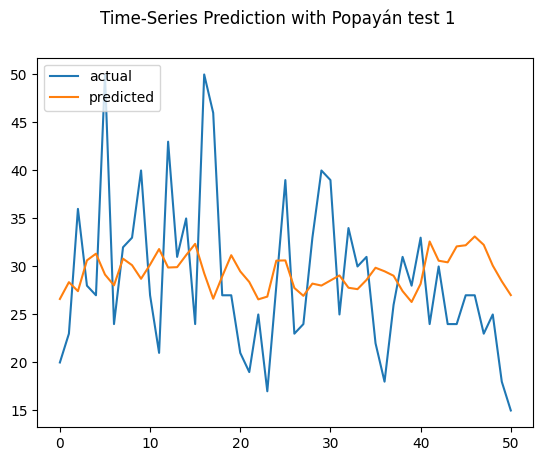

2024-01-16 15:58:03.943677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:04.457217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:04.599949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:05.585748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:06.077091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:07.966753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:08.156288: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 12.
Epoch 20: early stopping


2024-01-16 15:58:38.634194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:38.874490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 1s

2024-01-16 15:58:39.080590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 191ms/step
Test MAE: 6.426
Test RMSE: 8.445
Test sMAPE: 22.045
Test R Squared: -0.113
{'mae': 6.426310782339058, 'rmse': 8.445470696121674, 'smape': 22.044524799848137, 'r2': -0.11270369524500268}


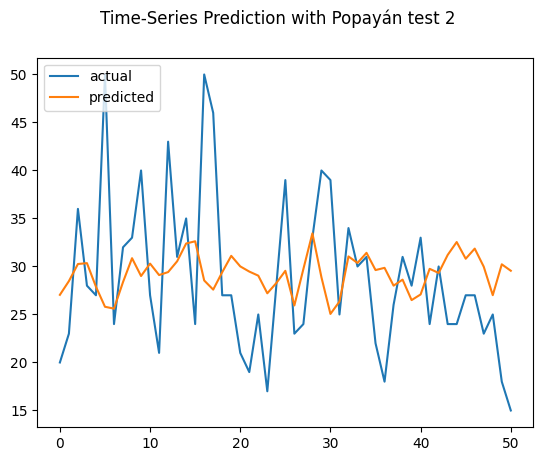

rmse : average=8.305, std=0.123
mae : average=6.629, std=0.170
smape : average=22.742, std=0.570
r2 : average=-0.076, std=0.032


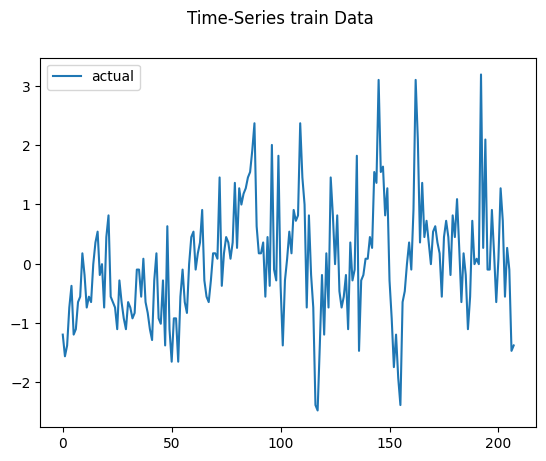

2024-01-16 15:58:46.660268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:47.415842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:47.721352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:49.348410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:49.926665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:52.480914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:58:52.681238: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping


2024-01-16 15:59:03.166559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:03.353068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2024-01-16 15:59:03.502884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 122ms/step
Test MAE: 8.060
Test RMSE: 10.730
Test sMAPE: 26.744
Test R Squared: 0.014
{'mae': 8.06021230361041, 'rmse': 10.729674935806083, 'smape': 26.744098238716138, 'r2': 0.013895288454934263}


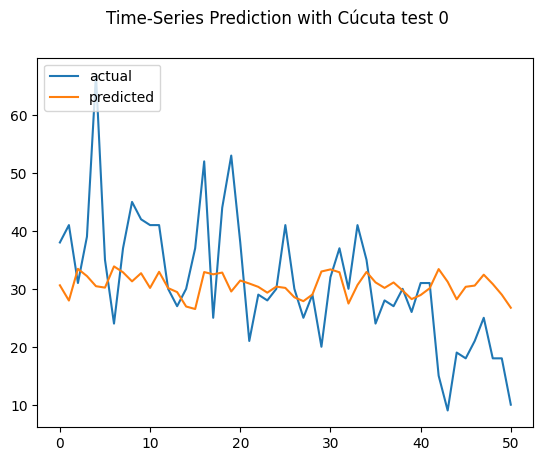

2024-01-16 15:59:06.260199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:06.667855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:06.794780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:07.933480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:08.333545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:10.312332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:10.493615: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping


2024-01-16 15:59:18.888589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:19.067179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2024-01-16 15:59:19.191650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 1s 126ms/step
Test MAE: 8.211
Test RMSE: 10.753
Test sMAPE: 27.285
Test R Squared: 0.010
{'mae': 8.210838617063036, 'rmse': 10.75315306221436, 'smape': 27.284914908997767, 'r2': 0.00957507911017641}


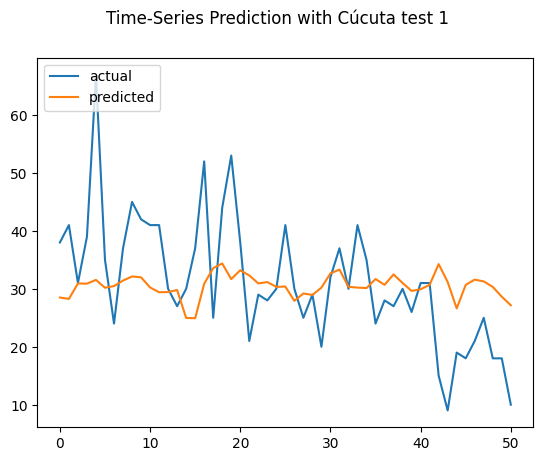

2024-01-16 15:59:22.428008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:22.910813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:23.039313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:24.058725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:24.497058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:26.610014: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:26.845888: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2024-01-16 15:59:35.589873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:35.994886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 15:59:36.387190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 256ms/step
Test MAE: 7.960
Test RMSE: 10.470
Test sMAPE: 26.455
Test R Squared: 0.061
{'mae': 7.960307139976352, 'rmse': 10.47033791217468, 'smape': 26.45523046244865, 'r2': 0.060987658767598596}


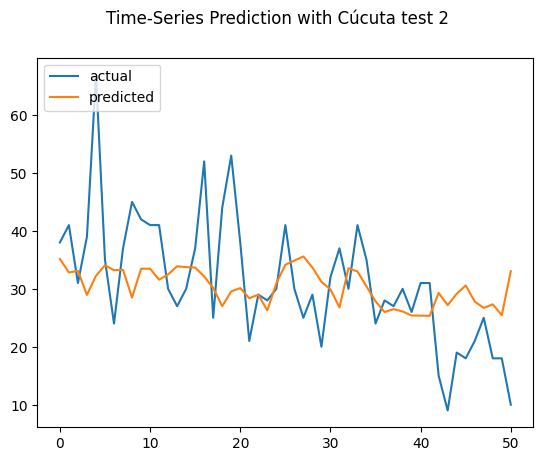

rmse : average=10.651, std=0.128
mae : average=8.077, std=0.103
smape : average=26.828, std=0.344
r2 : average=0.028, std=0.023


In [14]:
# Use the Function:
if T != 0: 
    sequence=train_X[0].shape[1]
    features=train_X[0].shape[2]
else:
    sequence=T
    features=train_X[0].shape[1]

results_list = []
for i in range(len(train_X)):
    set_all_seeds(1)
    results = calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X[i], train_y[i], test_X[i], test_y[i], scalers_list[i]['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality=Municipalities[i])
    results_list.append(results)

In [15]:
for i in range(len(train_X)):
    print(f'The results for {Municipalities[i]} are:')
    print(f'RMSE: {results_list[i][0]}')
    print(f'MAE: {results_list[i][1]}')
    print(f'sMAPE: {results_list[i][2]}')
    print('R squared: ', results_list[i][3])
    print('\n')

The results for Medellín are:
RMSE: [32.66736686026702, 1.3851276092452813]
MAE: [24.87113144818474, 1.7086385538579834]
sMAPE: [15.000428273750037, 0.9753211665981266]
R squared:  [0.08017097805485218, 0.07833427368983945]
([32.66736686026702, 1.3851276092452813], [24.87113144818474, 1.7086385538579834], [15.000428273750037, 0.9753211665981266], [0.08017097805485218, 0.07833427368983945])


The results for Cali are:
RMSE: [24.77475112452707, 0.2085429277339312]
MAE: [20.28584793190551, 0.27267167236549034]
sMAPE: [18.349053916347877, 0.19948320891190038]
R squared:  [-0.08810796779541337, 0.018361214742745897]
([24.77475112452707, 0.2085429277339312], [20.28584793190551, 0.27267167236549034], [18.349053916347877, 0.19948320891190038], [-0.08810796779541337, 0.018361214742745897])


The results for Soacha are:
RMSE: [26.81481896881181, 0.033003968803333734]
MAE: [20.450132158067493, 0.21206952526853273]
sMAPE: [37.5217429456257, 0.4972201907710239]
R squared:  [-0.4421765071700212, 0.0

### Late fusion

shape of x_ar: (208, 3, 10)
shape of x_ar_test: (51, 3, 10)
shape of train_X: (208, 3, 1040)
shape of test_X: (51, 3, 1040)


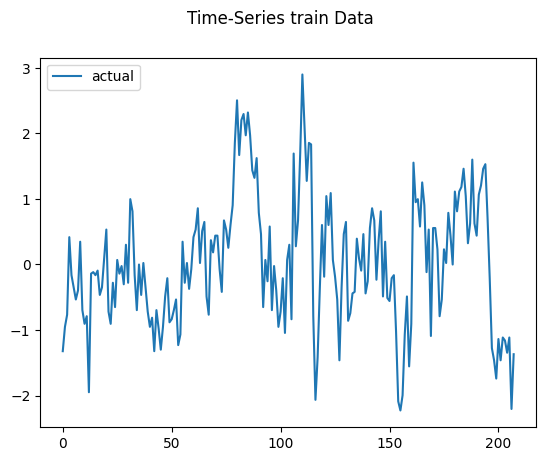

2024-01-16 16:00:03.288324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:06.071550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:06.384570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:07.959490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:08.645569: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:12.082733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:12.246681: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 15.
Epoch 23: early stopping


2024-01-16 16:00:29.453994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:29.872218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:30.017861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:31.943037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:32.533534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:36.695523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:37.078774: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 16:00:46.919594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:48.873804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:48.896910: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:49.117621: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:51.633437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:54.723274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:00:55.098135: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_60_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_62_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_30 (Sequential)  (None, 1)                    1132497   ['lstm_60_input[0][0]']       
                                                          1                                       
                           

2024-01-16 16:01:10.340397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:10.692280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:10.692700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:10.997598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:11.025222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 297ms/step
Test MAE: 23.092
Test RMSE: 32.172
Test sMAPE: 13.988
Test R Squared: 0.109
{'mae': 23.09207093481924, 'rmse': 32.17197765830475, 'smape': 13.98799747864904, 'r2': 0.10945827194648727}


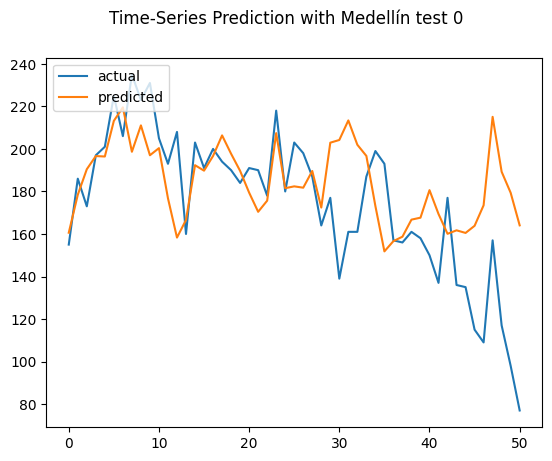

2024-01-16 16:01:15.100072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:15.582825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:15.716565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:17.289801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:18.357073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:25.242005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:25.773534: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 16:01:50.207067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:51.148676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:51.326611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:53.508451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:54.288720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:57.053857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:01:57.251394: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping


2024-01-16 16:02:06.617413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:07.278366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:07.301317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:07.447454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:07.550459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:10.051724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:10.673348: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_64_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_66_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_32 (Sequential)  (None, 1)                    1132497   ['lstm_64_input[0][0]']       
                                                          1                                       
                                                                                                  
 sequent

2024-01-16 16:02:50.220956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:50.693208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:50.695599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:51.050993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:51.094648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 312ms/step
Test MAE: 26.771
Test RMSE: 34.076
Test sMAPE: 16.053
Test R Squared: 0.001
{'mae': 26.77134614832261, 'rmse': 34.07552882469558, 'smape': 16.052665332189914, 'r2': 0.0009574949323601922}


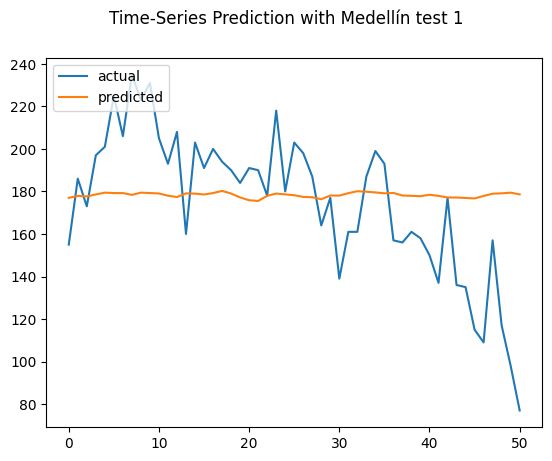

2024-01-16 16:02:54.733244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:55.227710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:55.363949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:56.395122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:56.905191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:59.340396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:02:59.554560: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping


2024-01-16 16:03:10.653373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:11.055578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:11.193828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:12.119358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:12.461554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:14.267398: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:14.423121: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping


2024-01-16 16:03:38.022168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:38.885679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:38.898683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:39.136006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:39.174784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:42.071956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:03:42.662183: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_68_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_70_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_34 (Sequential)  (None, 1)                    1132497   ['lstm_68_input[0][0]']       
                                                          1                                       
                                                                                                  
 sequenti

2024-01-16 16:04:14.439949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:14.865506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:14.865556: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:15.313137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:15.329140: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 2s 320ms/step
Test MAE: 24.075
Test RMSE: 32.517
Test sMAPE: 14.540
Test R Squared: 0.090
{'mae': 24.07458885043275, 'rmse': 32.516610085321076, 'smape': 14.539910312264977, 'r2': 0.09027677197483974}


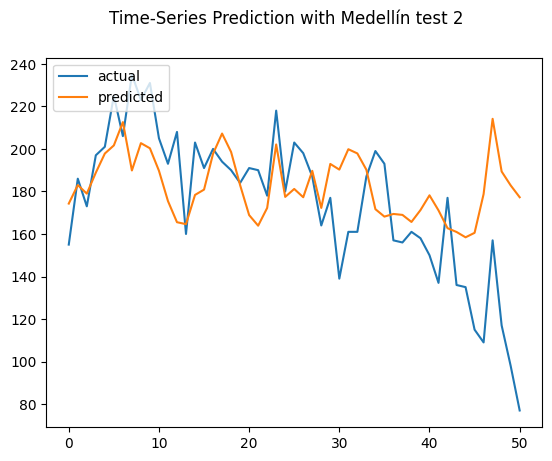

rmse : average=32.921, std=0.828
mae : average=24.646, std=1.555
smape : average=14.860, std=0.873
r2 : average=0.067, std=0.047
shape of x_ar: (208, 3, 10)
shape of x_ar_test: (51, 3, 10)
shape of train_X: (208, 3, 1040)
shape of test_X: (51, 3, 1040)


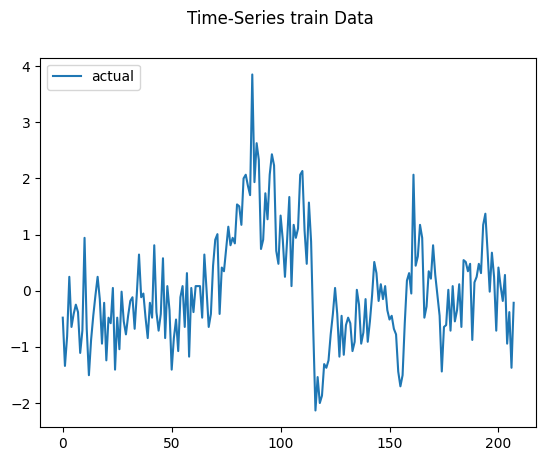

2024-01-16 16:04:28.042241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:28.774745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:28.924980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:30.050770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:31.013248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:36.192296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:36.458089: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 16:04:46.080122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:46.773234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:46.925855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:48.027203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:48.473551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:50.427582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:04:50.692789: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 24.
Epoch 32: early stopping


2024-01-16 16:05:12.262007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:12.988792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:13.002493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:13.171443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:13.422273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:15.579449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:15.951853: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_72_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_74_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_36 (Sequential)  (None, 1)                    1132497   ['lstm_72_input[0][0]']       
                                                          1                                       
                       

2024-01-16 16:05:50.166905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:50.784033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:50.784310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:51.445929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:52.094613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 16s 633ms/step
Test MAE: 20.527
Test RMSE: 25.152
Test sMAPE: 18.651
Test R Squared: -0.121
{'mae': 20.526591132668887, 'rmse': 25.152015391185305, 'smape': 18.650963851894172, 'r2': -0.12141974577599668}


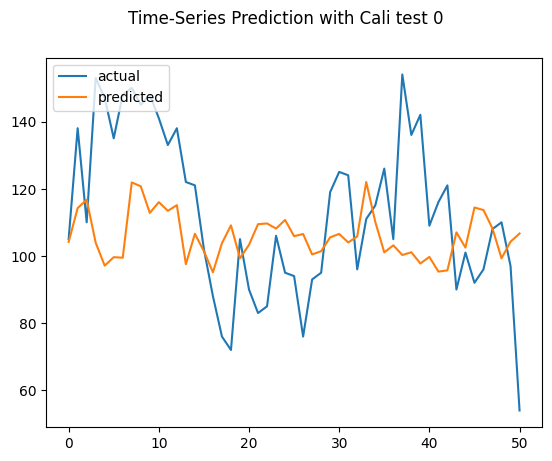

2024-01-16 16:05:56.891723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:57.410575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:57.583017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:05:59.366746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:00.456549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:06.859965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:08.220423: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2024-01-16 16:06:43.825376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:44.767798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:45.055417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:47.144181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:48.034255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:51.555351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:06:51.999931: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping


2024-01-16 16:07:21.608454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:07:23.385067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:07:23.413234: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:07:23.889348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:07:24.015909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:07:28.496633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:07:31.597372: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 19: early stopping
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_76_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_78_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_38 (Sequential)  (None, 1)                    1132497   ['lstm_76_input[0][0]']       
                                                          1                                       
                     

2024-01-16 16:08:13.104109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:08:13.653348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:08:13.656109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:08:14.220445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:08:14.221733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 5s 1s/step
Test MAE: 19.927
Test RMSE: 24.585
Test sMAPE: 18.029
Test R Squared: -0.071
{'mae': 19.927155588187425, 'rmse': 24.585486330327413, 'smape': 18.028894409767414, 'r2': -0.07147051801051751}


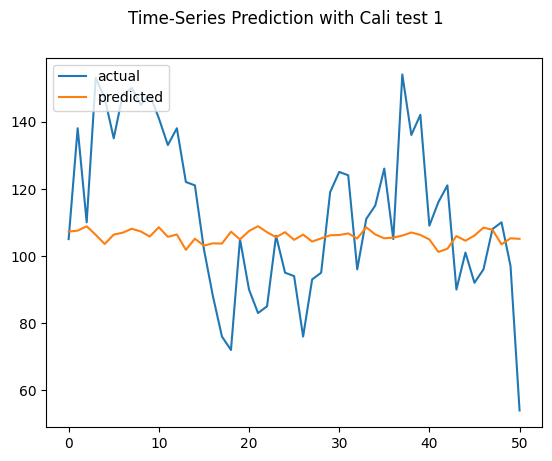

2024-01-16 16:09:20.210105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:09:24.520938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:09:24.776000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:09:26.733235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:09:31.929605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:09:45.373251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:09:47.326358: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2024-01-16 16:11:36.619728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:11:42.135718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:11:42.511571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:11:47.046096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:11:50.099612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:12:00.743923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:12:02.977887: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 24.
Epoch 32: early stopping


2024-01-16 16:12:50.366619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:12:54.340830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:12:54.753860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:12:55.326167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:12:58.140492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:13:05.208086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:13:06.135071: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_80_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_82_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_40 (Sequential)  (None, 1)                    1132497   ['lstm_80_input[0][0]']       
                                                          1                                       
                      

2024-01-16 16:14:11.480244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:14:12.330599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:14:12.333096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:14:13.060815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:14:13.118404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 6s 843ms/step
Test MAE: 20.276
Test RMSE: 24.283
Test sMAPE: 18.384
Test R Squared: -0.045
{'mae': 20.276027754241344, 'rmse': 24.283351397028863, 'smape': 18.383540755174945, 'r2': -0.045297393532858}


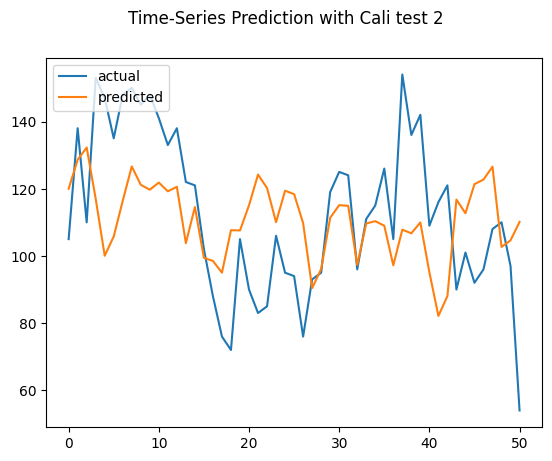

rmse : average=24.674, std=0.360
mae : average=20.243, std=0.246
smape : average=18.354, std=0.255
r2 : average=-0.079, std=0.032
shape of x_ar: (208, 3, 10)
shape of x_ar_test: (51, 3, 10)
shape of train_X: (208, 3, 1040)
shape of test_X: (51, 3, 1040)


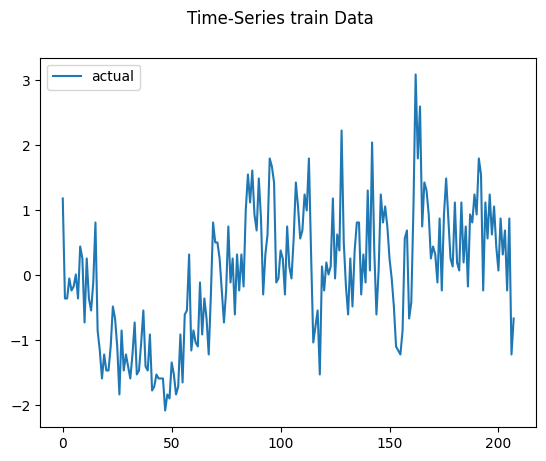

2024-01-16 16:15:28.765787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:15:39.498174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:15:40.256071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:15:44.050941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:15:49.180336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:16:22.530135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:16:23.556816: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 16.
Epoch 24: early stopping


2024-01-16 16:17:00.177327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:17:02.742945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:17:03.242941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:17:06.078446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:17:08.614206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:17:15.106773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:17:16.304953: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping


2024-01-16 16:18:50.634416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:18:54.170706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:18:54.217252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:18:54.819359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:18:55.421289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:19:04.981044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:19:06.405485: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 27.
Epoch 35: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_84_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_86_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_42 (Sequential)  (None, 1)                    1132497   ['lstm_84_input[0][0]']       
                                                          1                                       
                      

2024-01-16 16:19:55.084833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:19:56.618826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:19:56.620023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:19:59.432854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:19:59.556288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 11s 898ms/step
Test MAE: 20.046
Test RMSE: 26.376
Test sMAPE: 36.799
Test R Squared: -0.395
{'mae': 20.04645485971488, 'rmse': 26.37632300687123, 'smape': 36.79898979066018, 'r2': -0.3953929527641584}


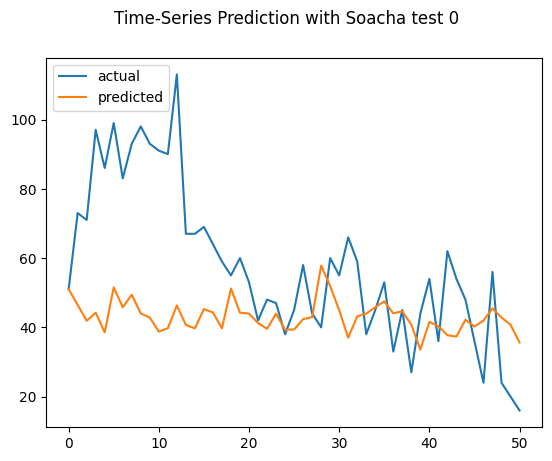

2024-01-16 16:20:27.873988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:20:29.957296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:20:30.335995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:20:33.121790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:20:34.125889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:20:41.595606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:20:42.190184: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 17.
Epoch 25: early stopping


2024-01-16 16:21:23.479789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:21:27.960089: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:21:28.239550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:21:31.544565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:21:37.134705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:21:52.817784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:21:54.528180: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 25.
Epoch 33: early stopping


2024-01-16 16:23:00.881795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:23:03.061501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:23:03.168528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:23:03.412855: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:23:05.046601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:23:11.913363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:23:13.103029: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 38.
Epoch 46: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_88_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_90_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_44 (Sequential)  (None, 1)                    1132497   ['lstm_88_input[0][0]']       
                                                          1                                       
                       

2024-01-16 16:24:16.373029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:19.016758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:19.017717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:19.844905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:20.038290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 7s 656ms/step
Test MAE: 19.508
Test RMSE: 26.211
Test sMAPE: 35.629
Test R Squared: -0.378
{'mae': 19.508135776893766, 'rmse': 26.210529557092578, 'smape': 35.62882739083337, 'r2': -0.37790606322962006}


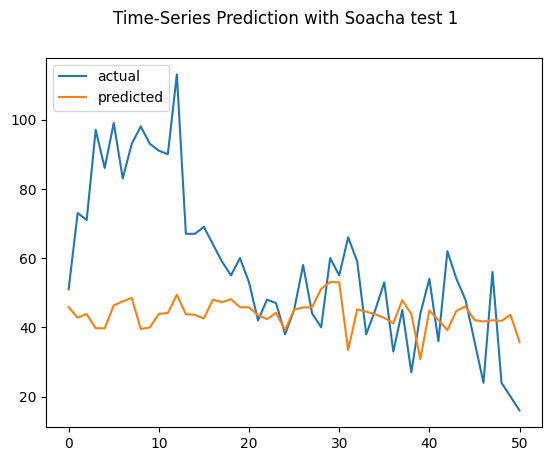

2024-01-16 16:24:26.364582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:27.216079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:27.403451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:29.090087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:30.111886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:39.412815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:24:40.408197: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 16:26:23.259090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:26:28.540837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:26:30.212315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:26:35.883383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:26:40.843540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:26:55.742176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:26:56.365305: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 21.
Epoch 29: early stopping


2024-01-16 16:27:53.478839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:28:05.288518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:28:05.415838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:28:10.070749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:28:10.312717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:28:46.861180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:28:53.861774: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 11: early stopping
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_92_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_94_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_46 (Sequential)  (None, 1)                    1132497   ['lstm_92_input[0][0]']       
                                                          1                                       
                       

2024-01-16 16:30:52.429595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:30:54.231905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:30:54.513053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:30:55.940943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:30:56.598375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 10s 943ms/step
Test MAE: 20.151
Test RMSE: 26.328
Test sMAPE: 37.262
Test R Squared: -0.390
{'mae': 20.1505443722594, 'rmse': 26.32766367642771, 'smape': 37.261981160054674, 'r2': -0.3902492292464177}


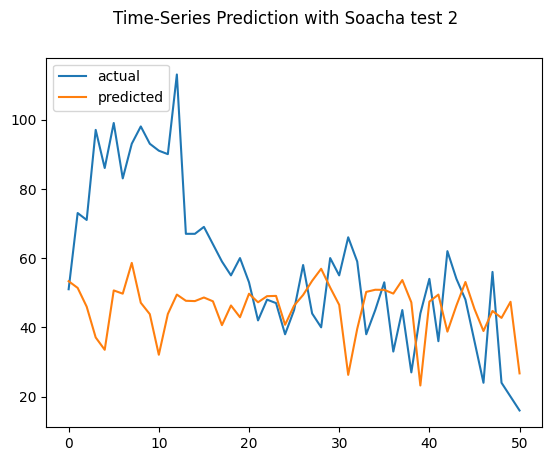

rmse : average=26.305, std=0.070
mae : average=19.902, std=0.282
smape : average=36.563, std=0.687
r2 : average=-0.388, std=0.007
shape of x_ar: (208, 3, 10)
shape of x_ar_test: (51, 3, 10)
shape of train_X: (208, 3, 1040)
shape of test_X: (51, 3, 1040)


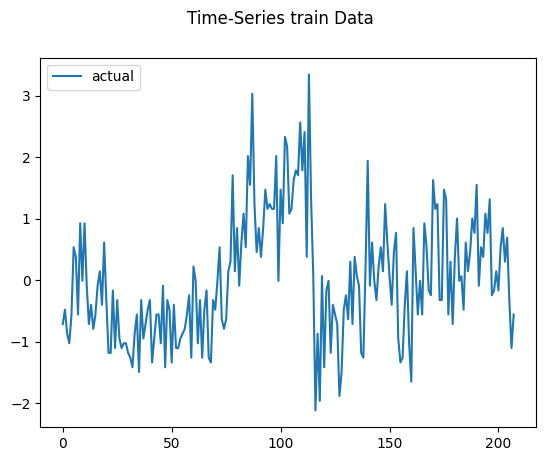

2024-01-16 16:31:40.489948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:31:43.315246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:31:43.650072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:31:49.641665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:31:51.903035: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:32:07.016339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:32:07.700322: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping


2024-01-16 16:33:04.743548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:33:08.021395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:33:08.928952: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:33:12.800992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:33:16.657495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:33:25.675579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:33:27.166257: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 13.
Epoch 21: early stopping


2024-01-16 16:35:39.144452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:35:43.239198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:35:43.274971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:35:44.053635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:35:44.134375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:36:01.235893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:36:03.389693: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 28.
Epoch 36: early stopping
Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_96_input (InputLayer)  [(None, 3, 1040)]            0         []                            
                                                                                                  
 lstm_98_input (InputLayer)  [(None, 3, 10)]              0         []                            
                                                                                                  
 sequential_48 (Sequential)  (None, 1)                    1132497   ['lstm_96_input[0][0]']       
                                                          1                                       
                                                                                                  
 sequen

2024-01-16 16:37:35.305065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:37:36.837300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:37:36.854152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:37:38.931520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:37:38.939351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 21s 5s/step
Test MAE: 10.338
Test RMSE: 13.147
Test sMAPE: 23.697
Test R Squared: -0.139
{'mae': 10.338242586921243, 'rmse': 13.14696163382572, 'smape': 23.697495976028875, 'r2': -0.13907002990692008}


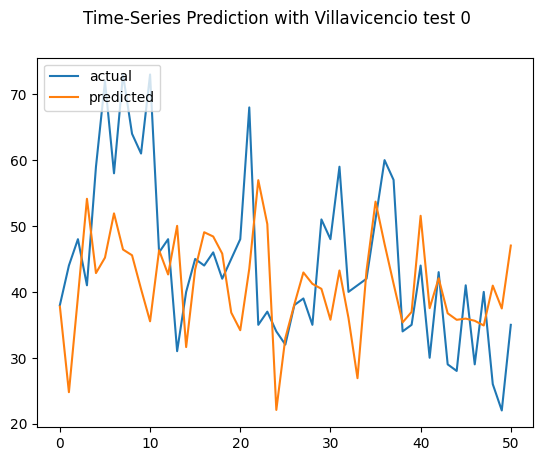

2024-01-16 16:38:05.610825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:08.284747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:08.578803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:12.563126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:14.078669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:19.869261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:20.393995: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 16:38:41.878098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:42.719866: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:42.976237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:44.988994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:45.791700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:50.146371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:38:50.394193: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 19.
Epoch 27: early stopping


2024-01-16 16:39:13.297823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:39:14.455551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:39:14.602723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:39:14.929795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:39:15.192053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:39:18.973735: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:39:19.795533: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_100_input (InputLayer  [(None, 3, 1040)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_102_input (InputLayer  [(None, 3, 10)]              0         []                            
 )                                                                                                
                                                                                                  
 sequential_50 (Sequential)  (None, 1)                    1132497   ['lstm_100_input[0][0]']      
       

2024-01-16 16:40:02.505532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:02.980574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:02.981044: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:03.778223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:03.857025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 3s 771ms/step
Test MAE: 10.762
Test RMSE: 13.691
Test sMAPE: 24.614
Test R Squared: -0.235
{'mae': 10.762242522894168, 'rmse': 13.690626793471706, 'smape': 24.61361725185244, 'r2': -0.2352256394032679}


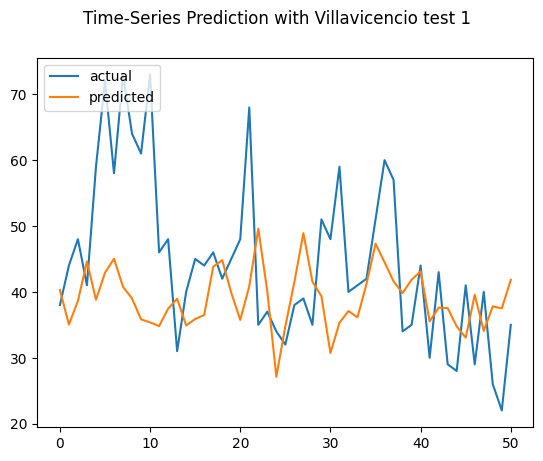

2024-01-16 16:40:42.578616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:45.036311: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:45.337438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:48.457321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:40:51.678916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:41:05.230453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:41:06.245056: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 16:42:24.697288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:42:28.650081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:42:36.747712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:42:50.013199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:42:55.243854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:43:19.962453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:43:21.988112: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 12.
Epoch 20: early stopping


2024-01-16 16:44:54.437045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:45:08.343169: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:45:08.433839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:45:12.645708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:45:12.778506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:45:38.607536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:45:42.902851: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 18.
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping
Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_104_input (InputLayer  [(None, 3, 1040)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_106_input (InputLayer  [(None, 3, 10)]              0         []                            
 )                                                                                                
                                                                                                  
 sequential_52 (Sequen

2024-01-16 16:46:40.539860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:46:42.203739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:46:42.204809: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:46:42.851232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:46:43.897830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 10s 4s/step
Test MAE: 10.070
Test RMSE: 13.783
Test sMAPE: 23.018
Test R Squared: -0.252
{'mae': 10.07037046843884, 'rmse': 13.783291230232791, 'smape': 23.018222636400917, 'r2': -0.25200337409523055}


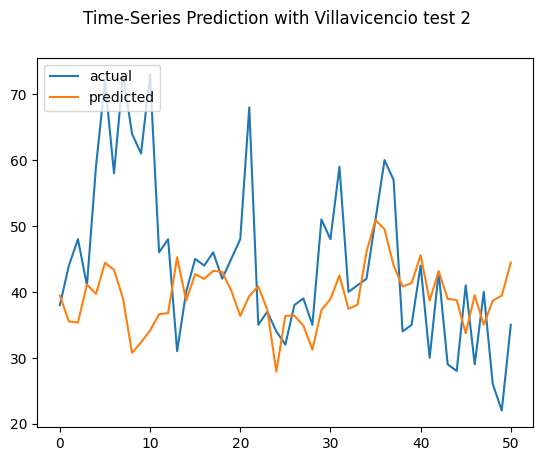

rmse : average=13.540, std=0.281
mae : average=10.390, std=0.285
smape : average=23.776, std=0.654
r2 : average=-0.209, std=0.050
shape of x_ar: (208, 3, 10)
shape of x_ar_test: (51, 3, 10)
shape of train_X: (208, 3, 1040)
shape of test_X: (51, 3, 1040)


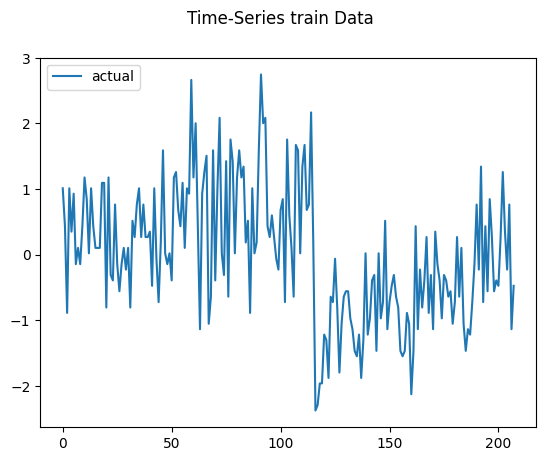

2024-01-16 16:47:57.118457: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:48:07.057935: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:48:07.443896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:48:11.637475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:48:17.962914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:48:53.731714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:48:54.140372: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 9.
Epoch 17: early stopping


2024-01-16 16:50:21.466625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:50:25.754491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:50:26.584216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:50:31.491296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:50:33.776839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:50:46.100754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:50:47.125332: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 16:51:14.483437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:51:16.403244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:51:16.705553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:51:18.191043: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:51:19.072941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:51:34.955367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:51:36.977419: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 14.
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 16: early stopping
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_108_input (InputLayer  [(None, 3, 1040)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_110_input (InputLayer  [(None, 3, 10)]              0         []                            
 )                                                                                                
                                                                                                  
 sequential_54 (Seque

2024-01-16 16:53:22.419231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:53:24.033179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:53:24.034199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:53:31.700858: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:53:40.753066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 48s 11s/step
Test MAE: 12.146
Test RMSE: 15.743
Test sMAPE: 29.118
Test R Squared: -0.329
{'mae': 12.145705653171913, 'rmse': 15.743404649363255, 'smape': 29.11812005774698, 'r2': -0.32853232080225503}


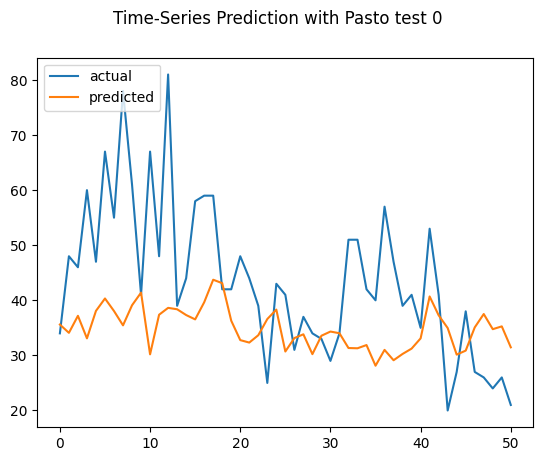

2024-01-16 16:54:32.489268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:54:37.742494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:54:38.238253: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:54:42.270670: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:54:47.541155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:55:39.752721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:55:41.259089: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 5.
Epoch 13: early stopping


2024-01-16 16:56:28.563161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:56:30.025284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:56:30.453218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:56:33.099947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:56:37.172153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:56:55.617232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:56:56.510722: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping


2024-01-16 16:58:40.245760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:58:48.333657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:58:48.359610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:58:49.335082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:58:49.516584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:59:07.686297: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 16:59:08.710744: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 7.
Epoch 15: early stopping
Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_112_input (InputLayer  [(None, 3, 1040)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_114_input (InputLayer  [(None, 3, 10)]              0         []                            
 )                                                                                                
                                                                                                  
 sequential_56 (Sequential)  (None, 1)                    1132497   ['lstm_112_input[0][0]']      
       

2024-01-16 17:02:16.862060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:02:22.689538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:02:22.690667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:02:28.859831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:02:29.116318: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 28s 8s/step
Test MAE: 11.712
Test RMSE: 15.446
Test sMAPE: 27.582
Test R Squared: -0.279
{'mae': 11.712211534088732, 'rmse': 15.445859757937772, 'smape': 27.58237438995427, 'r2': -0.27878926760340805}


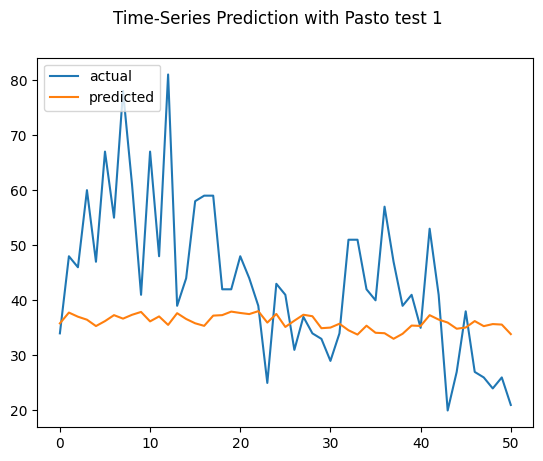

2024-01-16 17:02:50.974173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:02:54.275945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:02:55.203454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:03:04.829474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:03:15.181227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:03:47.036616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:03:48.222364: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 10.
Epoch 18: early stopping


2024-01-16 17:04:40.655669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:04:42.559845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:04:42.891517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:04:45.678240: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:04:48.144859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:04:58.085135: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:04:58.671403: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 1.
Epoch 9: early stopping


2024-01-16 17:05:21.286552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:05:23.246545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:05:23.273145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:05:23.732456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:05:24.754526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:05:35.066444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:05:36.168918: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 2.
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 12: early stopping
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_116_input (InputLayer  [(None, 3, 1040)]            0         []                            
 )                                                                                                
                                                                                                  
 lstm_118_input (InputLayer  [(None, 3, 10)]              0         []                            
 )                                                                                                
                                                                                                  
 sequential_58 (Sequen

2024-01-16 17:06:14.773816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:06:17.560698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:06:17.572589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:06:18.528415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:06:18.573264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 9s 2s/step
Test MAE: 11.967
Test RMSE: 16.136
Test sMAPE: 28.220
Test R Squared: -0.396
{'mae': 11.967258154177198, 'rmse': 16.13597224308646, 'smape': 28.220214673261122, 'r2': -0.39561325130826774}


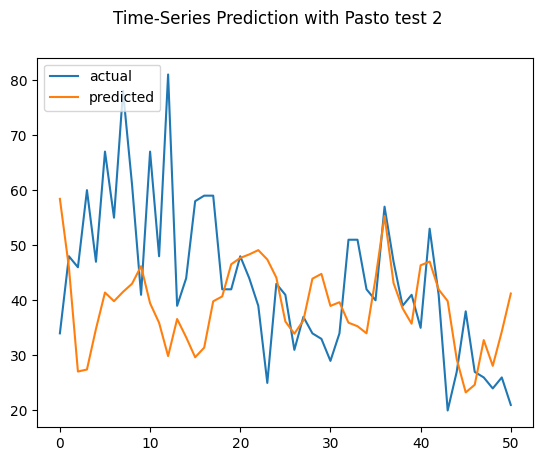

rmse : average=15.775, std=0.283
mae : average=11.942, std=0.178
smape : average=28.307, std=0.630
r2 : average=-0.334, std=0.048
shape of x_ar: (208, 3, 10)
shape of x_ar_test: (51, 3, 10)
shape of train_X: (208, 3, 1040)
shape of test_X: (51, 3, 1040)


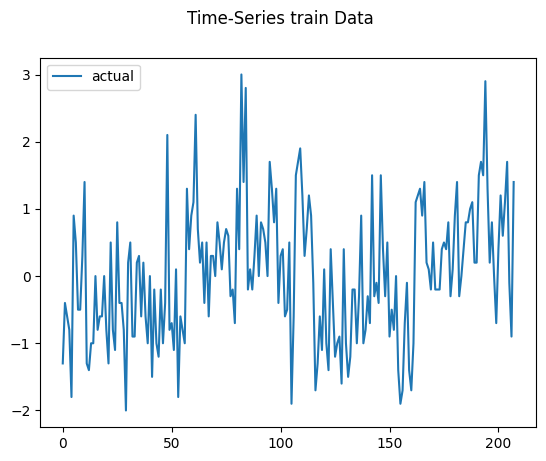

2024-01-16 17:07:45.074848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:08:11.485878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:08:15.986991: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:08:23.588584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:08:28.863714: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:09:15.827212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:09:19.082400: I tensorflow/core/grappler/optimizers/cust

Restoring model weights from the end of the best epoch: 6.
Epoch 14: early stopping


2024-01-16 17:10:48.695288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:10:53.005704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:10:54.192712: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:04.315444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-16 17:11:17.893962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [16]:
results_list_late = []
for i in range(len(train_X)):
    set_all_seeds(1)
    x_ar = train_X[i][:, :, :10]
    x_ar_test = test_X[i][:, :, :10]
    train_X[i] = train_X[i][:, :, 10:]
    test_X[i] = test_X[i][:, :, 10:]
    print(f'shape of x_ar: {x_ar.shape}')
    print(f'shape of x_ar_test: {x_ar_test.shape}')
    print(f'shape of train_X: {train_X[i].shape}')
    print(f'shape of test_X: {test_X[i].shape}')
    
    results = calculate_mean_std(lstm_layers, nn_layers, sequence, train_X[i].shape[2], dense_acivation, recurrent_cells, bidirectional, train_X[i], train_y[i], test_X[i], test_y[i], scalers_list[i]['scaler_Labels'], monitor=True, plot=None, epochs=50, batch_size=16, n_tests=n_tests, plot_samples=True, Municipality=Municipalities[i], fusion='late', x_ar=x_ar, x_ar_test=x_ar_test)
    results_list_late.append(results)

In [ ]:
for i in range(len(train_X)):
    print(f'The results for {Municipalities[i]} are:')
    print(results_list_late[i])
    print('\n')